# Pytorch workflow

**完整的Pytorch工作流程**

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

In [4]:
import torch
from torch import nn # nn包含了神经网络常用的模块和函数
import matplotlib.pyplot as plt

# check the pyTorch version
print(torch.__version__)

2.9.0+cu128


## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.(数据可以是anything)

* Excel speadsheet
  
* Images of any kind
  
* Videos (YouTube has lots of data...)
  
* Audio like songs or podcasts
  
* DNA 
  
* Text

Machine learning is a game of two parts: 
1. Get data into a numerical representation. (将数据转换成数值形式)
   
2. Build a model to learn patterns in that numerical representation. （构建模型去学习数值中的模式）
   
![machine learning is a game of two parts: 1. turn your data into a representative set of numbers and 2. build or pick a model to learn the representation as best as possible](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

To showcase this, let's create some *known* data using the linear regression formula. （使用线性回归公示来创建一些已知数据）

We'll use a linear regression formula to make a straight line with *known* **parameters**.  （使用线性回归公式画一条直线）

In [5]:
weights = 0.7
bias = 0.3

def linear_regression(x):
    return weights * x + bias #线性回归公式，可以理解为一个简单的神经网络

# Create some data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze在指定维度增加一个维度
y = linear_regression(X)

print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")
X[:10], y[:10] #查看前10个数据

Length of X: 50
Length of y: 50


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

**Note**：

X[start:stop:step]

start 默认 0，stop 默认到末尾，step 默认 1。

例子：X[:10:2] 取前10个里的偶数下标（步长为2）。

X[::-1] 反向（步长为 -1）。

负索引：X[-10:] 取最后10个。

多维切片独立指定各维：X[:10, :] 取前10行所有列；X[:, :5] 取所有行前5列。

返回的是“视图”（view），与原张量共享内存；对切片做原地修改会影响原张量（避免用 in-place 修改除非明确需要）。

### 划分数据集，分为训练集、验证集、测试集（最重要的概念之一）

In [6]:
train_split = int(0.8 * len(X)) # 80%作为训练集

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 40
Length of y_train: 40
Length of X_test: 10
Length of y_test: 10


How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!" （可视化）

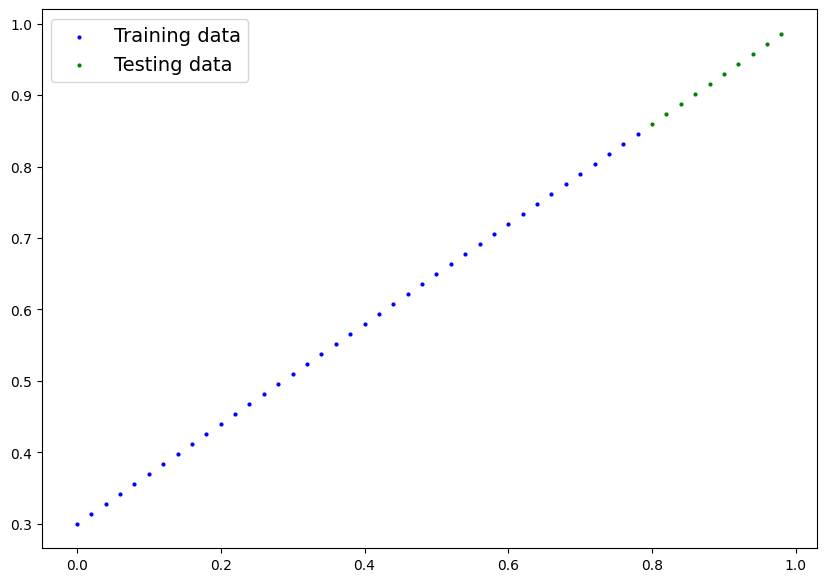

In [7]:
def plt_predictions(train_data=X_train,
                train_labels=y_train,
                test_data=X_test,
                test_labels=y_test,
                predictions=None):
    
    """
    plot.figure(figsize=(10, 7)) 设置图像大小
    plt.scatter() 绘制散点图
    plt.plot() 绘制折线图 (无s参数)
    plt.legend() 图例
    plt.show() 显示图像
    """

    plt.figure(figsize=(10, 7)) #设置图像大小

    plt.scatter(train_data, train_labels,c='b',s=4,label='Training data') #绘制训练数据（color,size,label）

    plt.scatter(test_data, test_labels,c='g',s=4,label='Testing data') #绘制测试数据 （color,size,label）

    if predictions is not None:

        plt.scatter(test_data, predictions,c='r',s=4,label='Predictions')

    plt.legend(prop={'size':14})

    plt.show()

plt_predictions()

## 2. Build model 

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
  
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [8]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        # 调用父类 nn.Module 的构造函数，完成必要的模块初始化
        super().__init__()
        # 可学习的“权重”参数（w）：
        # - 形状为 (1,)，用 torch.randn 随机初始化一个浮点数
        # - requires_grad=True 表示参与反向传播、可被优化器更新
        # - dtype=torch.float32 指定数据类型为 float32（PyTorch 默认、与大多数算子兼容）
        self.weights = nn.Parameter(
            torch.randn(
                1,
                requires_grad=True,
                dtype=torch.float32,
            )
        )
        # 可学习的“偏置”参数（b）：与上面的权重类似，但语义是偏置项
        self.bias = nn.Parameter(
            torch.randn(
                1,
                requires_grad=True,
                dtype=torch.float32,
            )
        )
    # 任何nn.Module子类都需要实现 forward 方法，定义前向传播逻辑
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        # 前向传播（定义模型对输入 x 的计算方式）
        # 线性回归公式：y = w * x + b
        # 其中：
        # - x 期望形状为 (N, 1) 或可与 (1,) 广播相容
        # - self.weights 形状为 (1,)
        # - self.bias 形状为 (1,)
        # 返回与 x 在样本维度上对应的预测张量
        return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
  
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us 
  
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
  
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
  
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation 

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html 

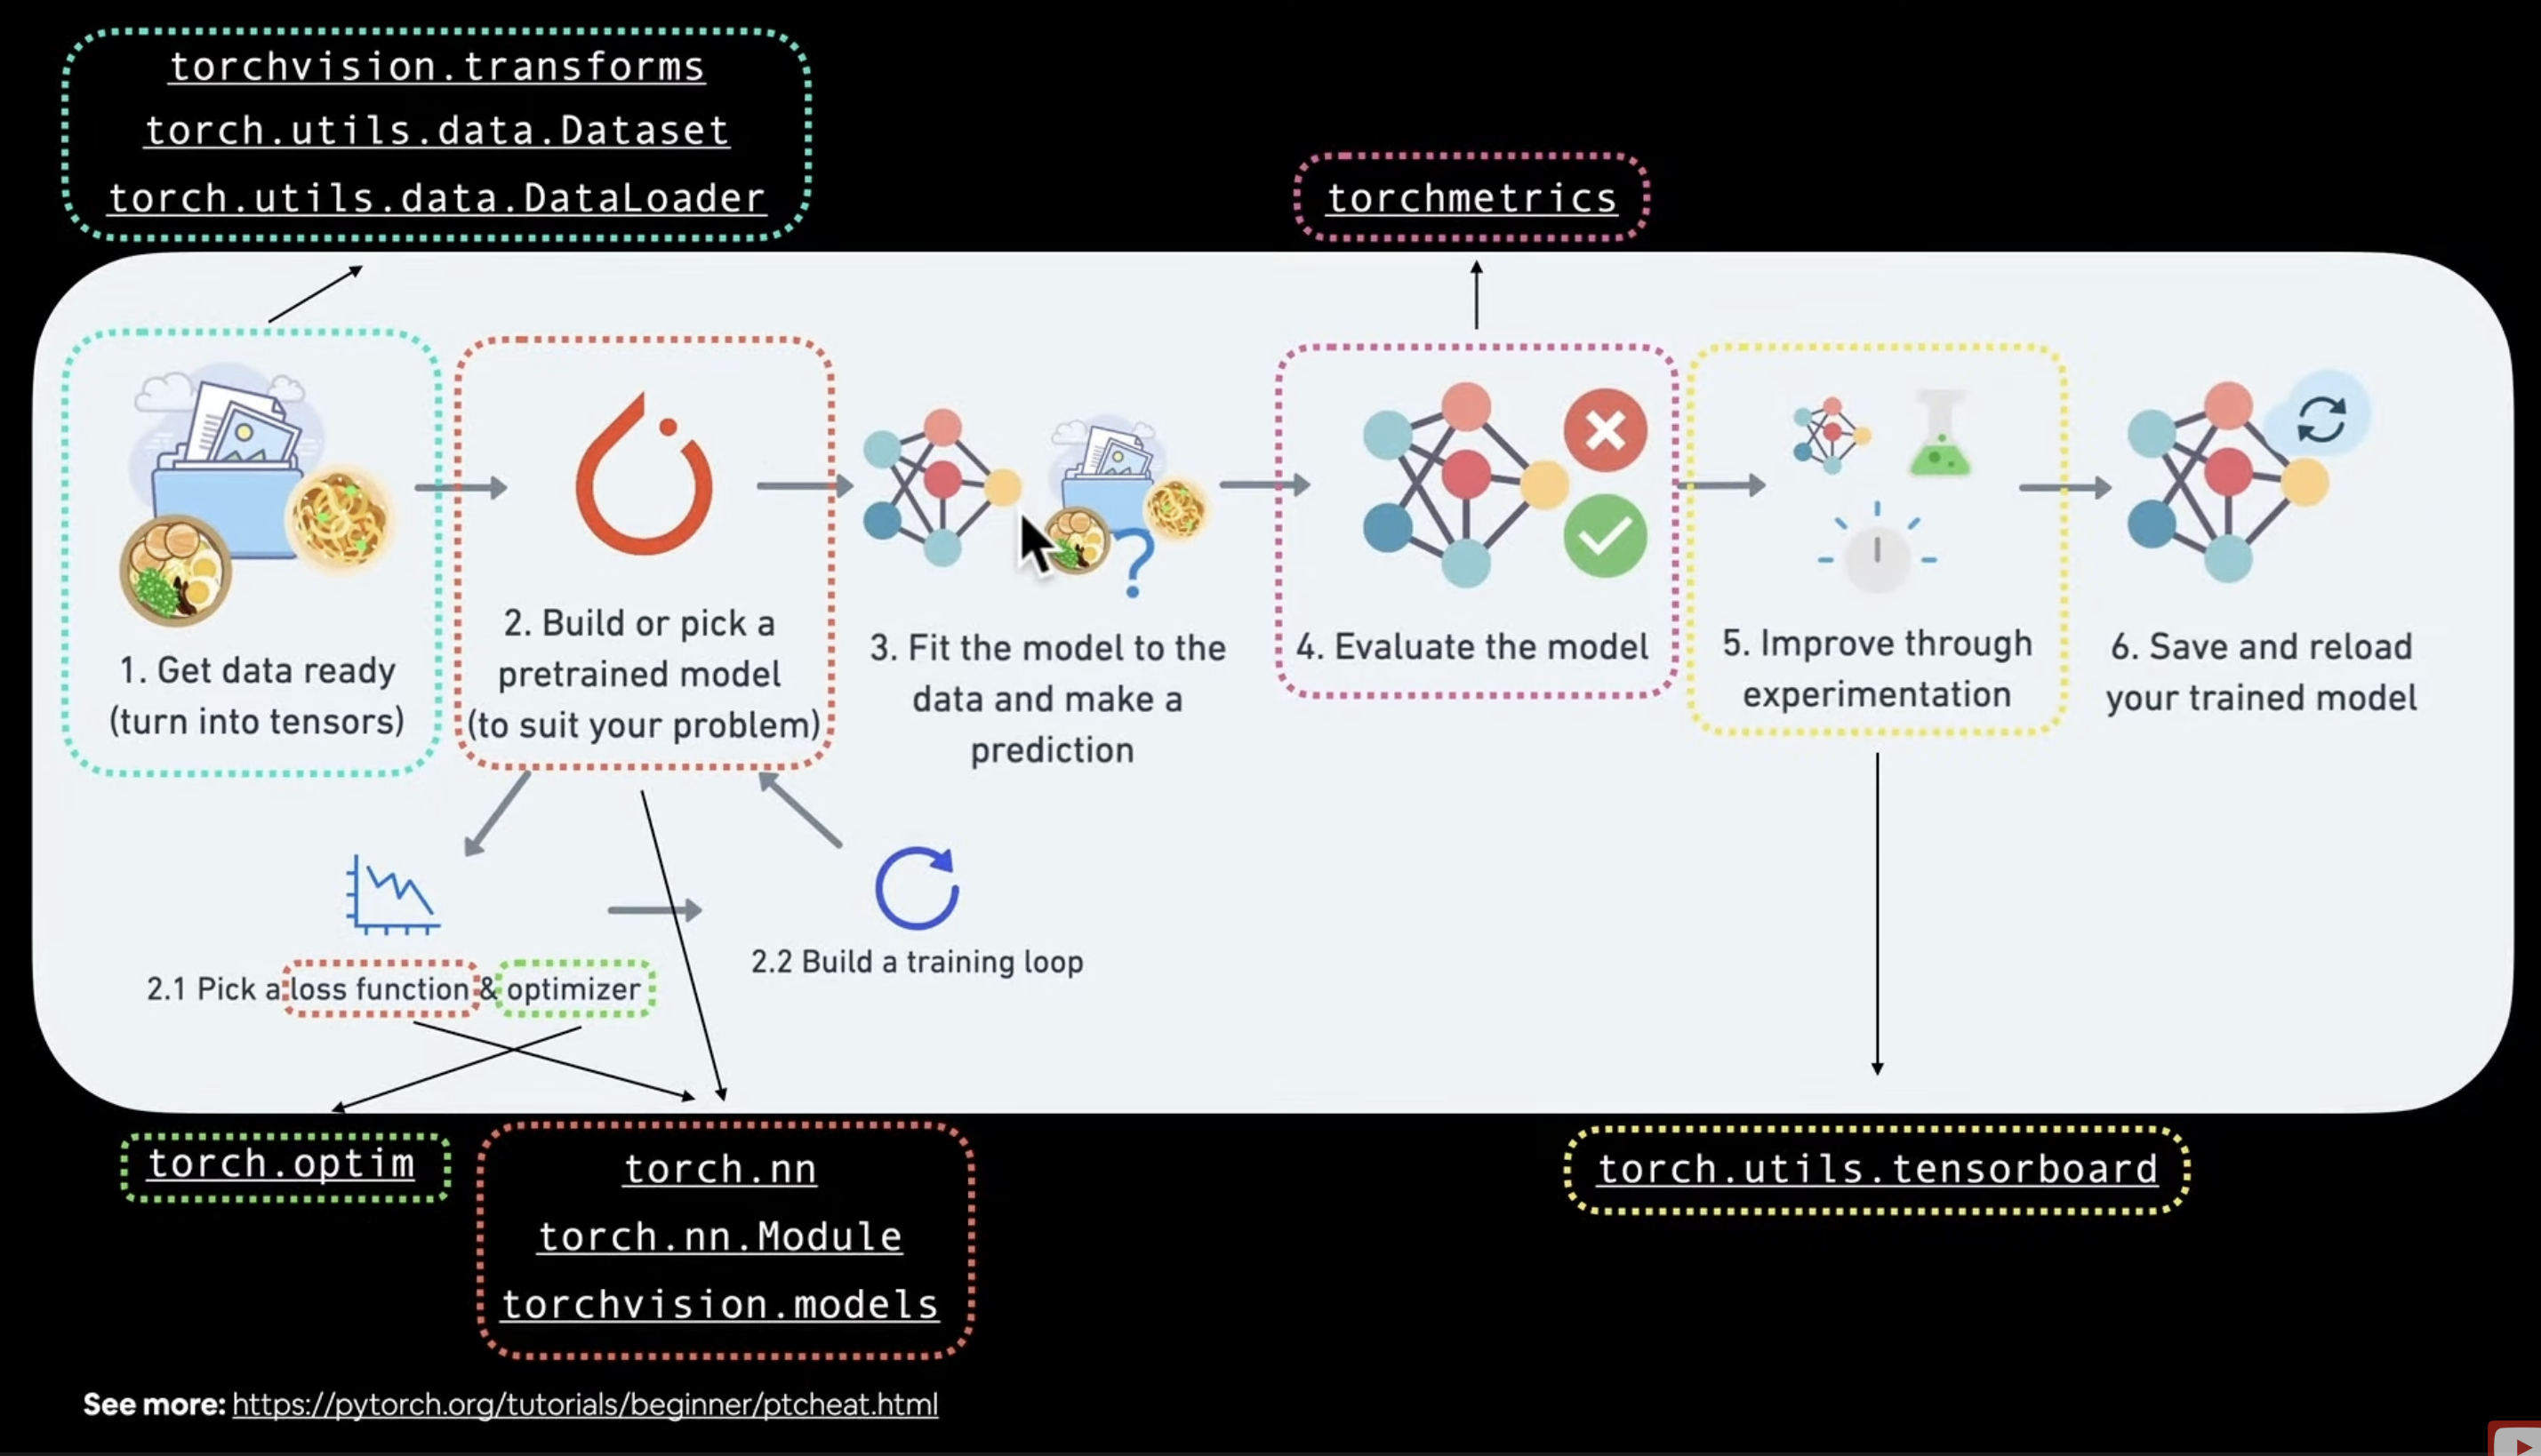

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`.

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model = LinearRegressionModel()
print(f"Model state dict: {model.state_dict()}") #查看模型的状态字典，包括可学习参数
print(f"Model parameters: {model.parameters()}") #查看模型的可学习参数
list(model.parameters())

Model state dict: OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})
Model parameters: <generator object Module.parameters at 0x7d8d713ba180>


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

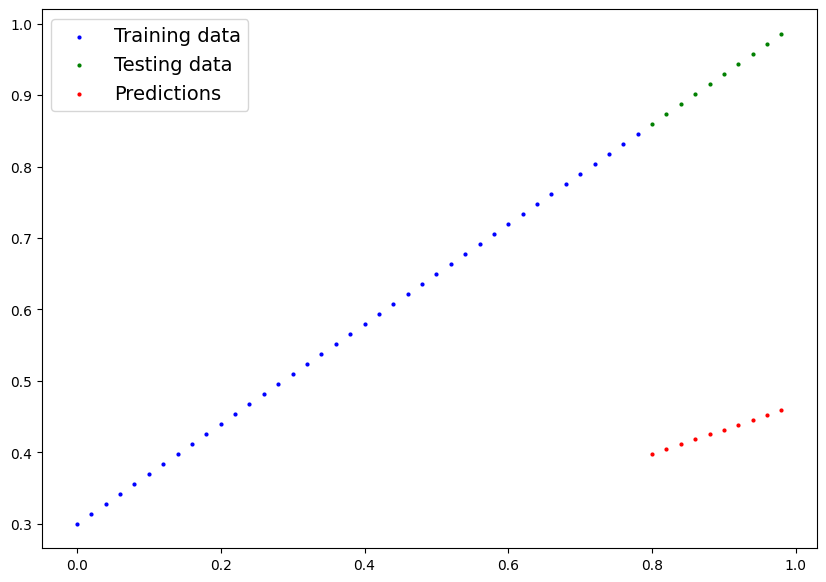

In [10]:
# check the power of predictions with untrained model
with torch.inference_mode(): #关闭梯度计算，节省内存和计算资源
    y_preds = model(X_test) #使用测试集进行预测
y_test
plt_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
  
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
  
  * Inside the optimizer you'll often have to set two parameters:
  
    * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
  
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:

* A training loop
  
* A testing loop

In [11]:
# Setup a loss function
loss_function= nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

> **Q:** Which loss function and optimizer should I use?
>
> **A:** This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.
>
> For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.
>
> But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss). 

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do...
   
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation 
   
2. Calculate the loss (compare forward pass predictions to ground truth labels)
   
3. Optimizer zero grad
   
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss 
(**backpropagation** - https://www.youtube.com/watch?v=tIeHLnjs5U8)

5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent** - https://youtu.be/IHZwWFHWa-w)

In [12]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 300

# Track different values，list
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model.train() # train mode in PyTorch sets all parameters that require gradients to require gradients （训练模式将所有需要梯度的参数设置为需要梯度）

  # 1. Forward pass （前向传播）
  y_pred = model(X_train)

  # 2. Calculate the loss （计算损失）
  loss = loss_function(y_pred, y_train)

  # 3. Optimizer zero grad （优化器梯度清零）
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter) （反向传播）
  loss.backward()

  # 5. Step the optimizer (perform gradient descent) （优化器更新参数）
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers) （评估模式关闭训练时不需要的设置）
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass （前向传播）
    test_pred = model(X_test)

    # 2. Calculate the loss （计算损失）
    test_loss = loss_function(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70 | Loss: 0.03

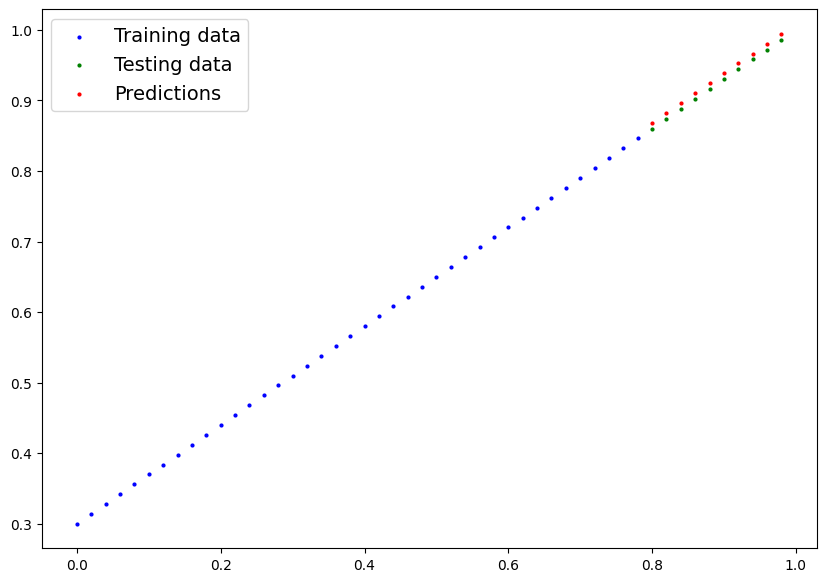

In [13]:
with torch.inference_mode():
    y_preds = model(X_test)
    plt_predictions(predictions=y_preds)

#### 绘制loss曲线

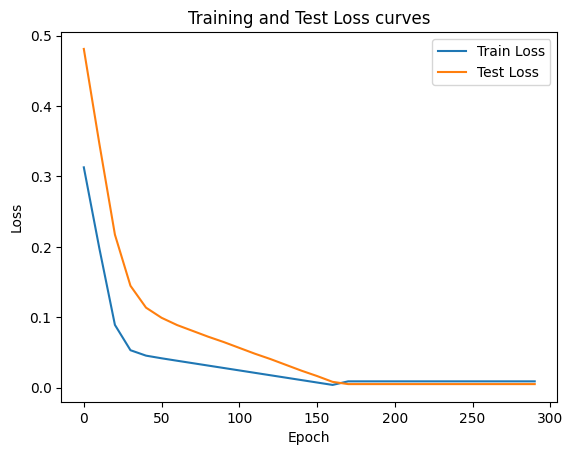

In [27]:
import numpy as np
with torch.inference_mode():
    plt.plot(epoch_count,torch.tensor(loss_values),label='Train Loss')
    plt.plot(epoch_count,torch.tensor(test_loss_values),label='Test Loss')
    plt.title("Training and Test Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format 
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary 

PyTorch save & load code tutorial + extra-curriculum - https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [31]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # create model directory if it doesn't exist

MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), # what we want to save
           f=MODEL_SAVE_PATH) # where we want to save it
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: models/01_pytorch_workflow_model.pth


### Load a model

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


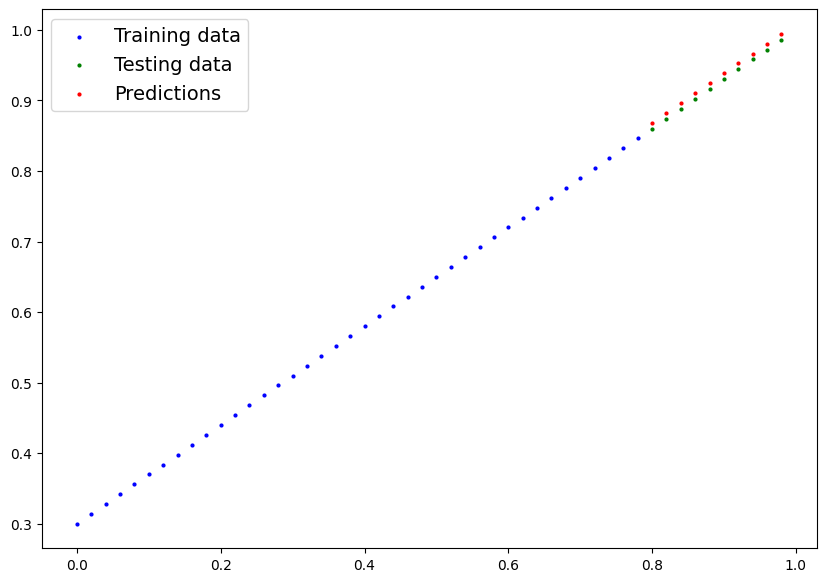

In [39]:
with torch.inference_mode():
    load_model = LinearRegressionModel()
    load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
    pre_output = load_model(X_test)
    print(pre_output)
    plt_predictions(predictions=pre_output)